
Import

In [255]:
import numpy as np
import random
from collections import OrderedDict
import csv
import matplotlib.pyplot as plt

Neural Network 모델 클래스


In [256]:
class Simple_Neural_Network:
    def __init__(self,params):
        # params=init_w_b()
        self.params=params
        
        # OrderedDict사용 이유: python의 일반적인 Dictionary는 key,Value 쌍이 추가되는 순서를 기억하지 않음. 
        # 순서가 달라도 같은 key,value값이 있으면 같다고 판단함
        # OrderedDict은 삽입된 순서를 기억하는 딕셔너리 자료형임. 순서까지 같아야 같다고 판단함.
        # self.layers=OrderedDict() 
        self.layers={} # 하지만 지금코드에선 이렇게 써도 무방.
        self.layers['Affine1']=Affine(self.params['W1'],self.params['B1']) 
        self.layers['Sigmoid1']=Sigmoid()
        self.layers['Affine2']=Affine(self.params['W2'],self.params['B2']) 
        self.layers['Sigmoid2']=Sigmoid()
        self.layers['Affine3']=Affine(self.params['W3'],self.params['B3']) 
        self.LastLayer=softmax_with_loss()
        
    def forward_pass(self,input): # 순전파 진행
        for layer in self.layers.values():
            input=layer.forward(input)

        return input
    
    def loss(self,input,t): 
        last_input=self.forward_pass(input)
        return self.LastLayer.forward(last_input,t) # 순전파 통과 후 loss 구함.
    
    def accuracy(self,input,t):
        y=self.forward_pass(input)
        y=np.argmax(y,axis=1) # y,t의 최대 인덱스
        t=np.argmax(t,axis=1)
        count=np.sum(y==t) # y와 t가 같은 것의 개수
        accuracy= count/ float(input.shape[0])
        return round(accuracy,6)  # 적당히 반올림해서 return
    
    def result_accuracy(self,input):  # matlab에서 예측 결과 시각화를 위해..
        y=self.forward_pass(input)
        y=np.argmax(y,axis=1) # y,t의 최대 인덱스
        return y
        
    
    def gradient(self,input,t):  # 순전파 및  역전파 진행후 각  parameter의 기울기 리턴(dict)
        self.loss(input,t) #순전파
        
        #역전파 시작
        dout=1
        dout=self.LastLayer.backward(dout)
        
        layers=list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout=layer.backward(dout)
            
        grad={}
        grad['W1']=self.layers['Affine1'].dW
        grad['B1']=self.layers['Affine1'].dB
        
        grad['W2']=self.layers['Affine2'].dW
        grad['B2']=self.layers['Affine2'].dB
        
        grad['W3']=self.layers['Affine3'].dW
        grad['B3']=self.layers['Affine3'].dB
        
        return grad



Affine 계층 클래스


In [257]:
class Affine:
    def __init__(self,W,B):
        self.W=W
        self.B=B
        self.X=None
        self.dW=None
        self.dB=None
    
    def forward(self,X):
        self.X=X
        out=np.dot(self.X, self.W)+self.B
        return out
    
    def backward(self,dout): # 행렬곱 => chain rule 
        dx=np.dot(dout,self.W.T)
        self.dW=np.dot(self.X.T,dout)
        self.dB=np.sum(dout,axis=0)
        return dx    


Sigmoid 계층 클래스

<img src = "../simple_network/Data/sigmoid.png" width = "200" height = "65">

미분 값 : sigmoid(x)*( 1 - sigmoid(x) )

In [258]:
class Sigmoid:
    def __init__(self):
        self.out=None
        
    def forward(self,X):
        self.out=1/(1+np.exp(-X))
        return self.out
    
    def backward(self, dout): #sigmoid 미분 * 이전 미분값 곱 (chain rule)
        dx=dout*(1.0-self.out)*self.out
        return dx


Softmax 와 Loss Function(cross entropy)계층 클래스

손실함수는 softmax 채용


<img src = "../simple_network/Data/cross_entropy.png" width = "200" height = "75">

In [259]:
class softmax_with_loss:
    def __init__(self):
        self.y=None
        self.loss=None
        self.t=None
        
    def forward(self,X,T):
        self.y=softmax_inbook(X) 
        self.t=T  
        self.loss=cross_entropy_error(self.y,self.t)
        return self.loss
    
    def backward(self, dout=1): # 책 참고.. softmax와 cross entropy 미분하면 (y-t)형태로 나옴..
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx



Input Data 초기화 함수


In [260]:
def init_xt():
    input_data=np.empty((0,3))
    t=np.empty((0,3))
    for i in range(1100):
        input_data=np.append(input_data, np.array([[random.randrange(0,300) for j in range(3)]]),axis=0)
        x=input_data[-1,0]
        if x<100:
            t=np.append(t,np.array([[1, 0, 0]]),axis=0)
        elif x<200:
            t=np.append(t,np.array([[0, 1, 0]]),axis=0)
        elif x<300:
            t=np.append(t,np.array([[0, 0, 1]]),axis=0)
        # print(x)

    return input_data,t

가중치 및 편향 초기화 함수


In [261]:
def init_w_b():
    # 0.01을 곱해주는 이유: w초기값이크면 gradient vanishing 문제가 발생함.
    weight_init_std=0.01
    params={}
    params['W1']=weight_init_std*np.random.randn(3,4)
    params['B1']=np.zeros(4)
    params['W2']=weight_init_std*np.random.randn(4,4)
    params['B2']=np.zeros(4)
    params['W3']=weight_init_std*np.random.randn(4,3)
    params['B3']=np.zeros(3)
    return params


Sigmoid 함수


In [262]:
def softmax(x):
    c=np.max(x)     # 오버플로 대책 딥러닝책 p.94
    exp_x=np.exp(x-c)
    sum_exp_x=np.sum(exp_x)
    y=exp_x/sum_exp_x
    return y

def softmax_inbook(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))



Cross Entropy 함수


In [263]:
def cross_entropy_error(y,t):
    delta=1e-7  # np.log에 0을 넣으면  계산을 할 수 없음 log(0)은 무한대이므로
    
    batch_size=y.shape[0]
    return -np.sum(t*np.log(y+delta))/batch_size



Main 함수

주피터 노트북으로 간편히 코드 수정하기 위해 main 사용 안함.


In [264]:
# if __name__ == '__main__':

Input Data 세팅


In [265]:
# 변경 데이터셋
my_dictionary = np.load("../simple_network/Data/weight_bias.npz", allow_pickle=True)
params=dict(my_dictionary)

read_input=np.load("../simple_network/Data/input_data_set.npz", allow_pickle=True)
read_t=np.load("../simple_network/Data/t_set.npz", allow_pickle=True)

# 기본 데이터셋
# my_dictionary = np.load("../simple_network/아주 깔끔한 데이터 1000/weight_bias.npz", allow_pickle=True)
# params=dict(my_dictionary)

# read_input=np.load("../simple_network/아주 깔끔한 데이터 1000/input_data_set.npz", allow_pickle=True)
# read_t=np.load("../simple_network/아주 깔끔한 데이터 1000/t_set.npz", allow_pickle=True)

XYZ=read_input["arr_0"]
t=read_t["arr_0"]

print(XYZ.shape[0])

5000


##  데이터셋 구분 Train set, Validation set, Test set

비율--> 600 : 200 : 200


In [266]:
# XYZ,t=init_xt() #데이터, 정답 초기
xyz_train_set=XYZ[0:3000,:]
t_train_set=t[0:3000,:]

xyz_validation_set=XYZ[3000:4000,:]
t_validation_set=t[3000:4000,:]

xyz_test_set=XYZ[4000:5000,:]
t_test_set=t[4000:5000,:]


xyz_triaing_set=XYZ[0:3000,:]
t_trainging_set=t[0:3000,:]


# xyz_train_set=XYZ[0:600,:]
# t_train_set=t[0:600,:]

# xyz_validation_set=XYZ[600:800,:]
# t_validation_set=t[600:800,:]

# xyz_test_set=XYZ[800:1000,:]
# t_test_set=t[800:1000,:]


# xyz_triaing_set=XYZ[0:600,:]
# t_trainging_set=t[0:600,:]


Hyper Parameter 세팅


In [267]:
network=Simple_Neural_Network(params)

# batch 나눠서 진행
epoch=3000
batch_size=50
iter_per_epoch=xyz_triaing_set.shape[0]/batch_size

iteration_num=epoch*iter_per_epoch
learning_rate=0.01
epoch_cnt=0

train_loss_list=[]
train_acc_list=[]
validation_acc_list=[]
test_acc_list=[]

train_loss_list=[]
test_loss_list=[]
validation_loss_list=[]

print(iter_per_epoch)
print(xyz_train_set[0])

60.0
[0.13712375 0.61538462 0.29765886]


Train 시작


In [268]:
# seed값을 설정하여 np.random.choice()에서의 랜덤성을 막음.
np.random.seed(seed=0)
batch_st=-batch_size
for i in range(int(iteration_num)):
    # batch_mask=np.random.choice(xyz_triaing_set.shape[0],batch_size)  # 랜덤으로 trian_set에서 뽑아옴
    
    if batch_st+batch_size<xyz_triaing_set.shape[0]:
        batch_st=batch_st+batch_size
    else:
        batch_st=0
    
    xyz_batch=xyz_triaing_set[batch_st:batch_st+batch_size]
    t_batch=t_trainging_set[batch_st:batch_st+batch_size]
    
    grad=network.gradient(xyz_batch,t_batch)
    
    for key in ('W1','B1','W2','B2','W3','B3'): 
        network.params[key]-=learning_rate*grad[key] # SGD사용
        # print(network.params)
    
    if i%iter_per_epoch==0:
        train_acc=network.accuracy(xyz_train_set,t_train_set)
        validation_acc=network.accuracy(xyz_validation_set,t_validation_set)
        test_acc=network.accuracy(xyz_test_set,t_test_set)
        train_acc_list.append(train_acc)
        validation_acc_list.append(validation_acc)
        test_acc_list.append(test_acc)
        
        
        train_loss_list.append(network.loss(xyz_train_set,t_train_set))
        test_loss_list.append(network.loss(xyz_validation_set,t_validation_set))
        validation_loss_list.append(network.loss(xyz_test_set,t_test_set))
        
        epoch_cnt+=1
        
        print("Train Set Accuracy : ",train_acc,"\tTest Set Accuracy : ",test_acc,
              "\tValidation Set Accuracy : ",validation_acc)
        

Train Set Accuracy :  0.338333 	Test Set Accuracy :  0.348 	Validation Set Accuracy :  0.314
Train Set Accuracy :  0.338333 	Test Set Accuracy :  0.348 	Validation Set Accuracy :  0.314
Train Set Accuracy :  0.338333 	Test Set Accuracy :  0.348 	Validation Set Accuracy :  0.314
Train Set Accuracy :  0.185667 	Test Set Accuracy :  0.194 	Validation Set Accuracy :  0.186
Train Set Accuracy :  0.320333 	Test Set Accuracy :  0.312 	Validation Set Accuracy :  0.326
Train Set Accuracy :  0.337333 	Test Set Accuracy :  0.328 	Validation Set Accuracy :  0.346
Train Set Accuracy :  0.337333 	Test Set Accuracy :  0.328 	Validation Set Accuracy :  0.346
Train Set Accuracy :  0.337333 	Test Set Accuracy :  0.328 	Validation Set Accuracy :  0.346
Train Set Accuracy :  0.337333 	Test Set Accuracy :  0.328 	Validation Set Accuracy :  0.346
Train Set Accuracy :  0.337333 	Test Set Accuracy :  0.328 	Validation Set Accuracy :  0.346
Train Set Accuracy :  0.337333 	Test Set Accuracy :  0.328 	Validation

결과 csv파일에 저장

In [269]:

resultt=network.result_accuracy(xyz_test_set)
np.savetxt('resultt.csv', resultt, delimiter=',')

## Plot

subplot을 통해 train, test, validiation set들을 따로 표현함.

다음 마지막 plot을 통해 모든 데이터의 그래프를 비교함.

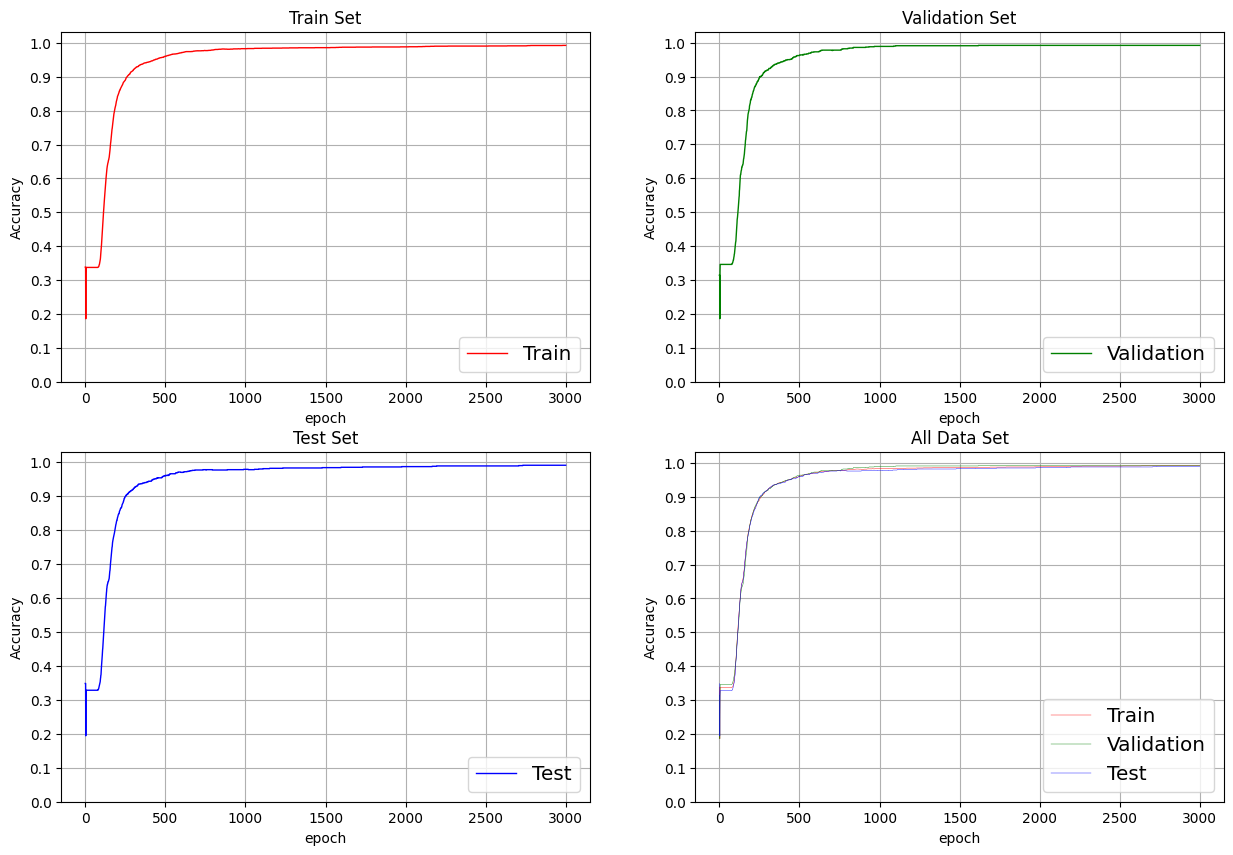

In [270]:
plt.figure(figsize=(15,10))  # figure size 조정
plt.subplot(2,2,1)

trian_plot = plt.plot(range(len(train_acc_list)),train_acc_list,label='Train')
plt.setp(trian_plot,color='r', linewidth=1)
plt.title('Train Set')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(fontsize='x-large', fancybox=True, loc='lower right')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)

plt.subplot(2,2,2)
validation_plot=plt.plot(range(len(validation_acc_list)),validation_acc_list,label='Validation')
plt.setp(validation_plot,color='g', linewidth=1)
plt.title('Validation Set')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(fontsize='x-large', fancybox=True, loc='lower right')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)


plt.subplot(2,2,3)
test_plot = plt.plot(range(len(test_acc_list)),test_acc_list,label='Test')
plt.title('Test Set')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.setp(test_plot,color='b', linewidth=1)
plt.legend(fontsize='x-large', fancybox=True, loc='lower right')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)

plt.subplot(2,2,4)
trian_plot = plt.plot(range(len(train_acc_list)),train_acc_list,label='Train')
validation_plot=plt.plot(range(len(validation_acc_list)),validation_acc_list,label='Validation')
test_plot = plt.plot(range(len(test_acc_list)),test_acc_list,label='Test')
plt.title('All Data Set')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.setp(validation_plot,color='g', linewidth=0.3)
plt.setp(trian_plot,color='r', linewidth=0.3)
plt.setp(test_plot,color='b', linewidth=0.3)
plt.legend(fontsize='x-large', fancybox=True, loc='lower right')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)

plt.show()



## Loss Plot
accuracy plot과 동일

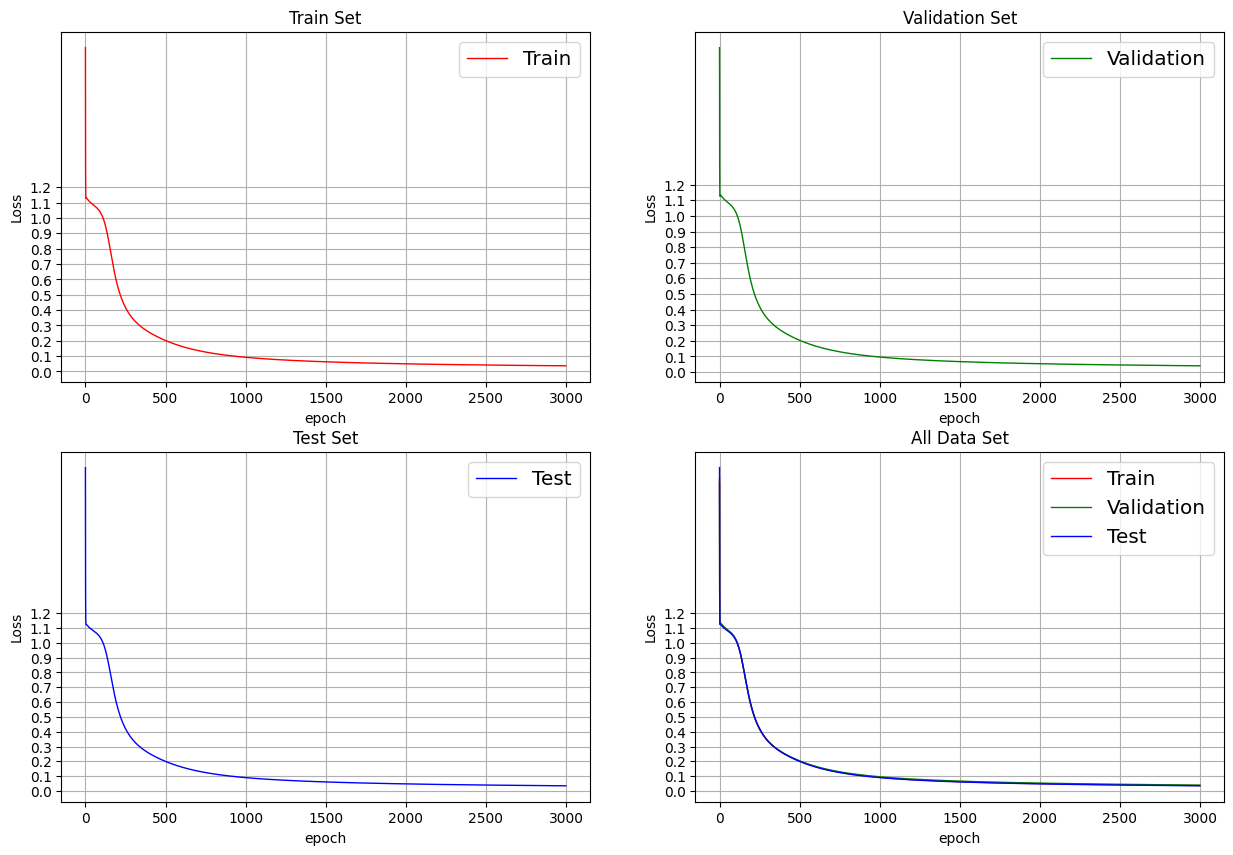

In [271]:
plt.figure(figsize=(15,10))  # figure size 조정
plt.subplot(2,2,1)
trian_loss_plot = plt.plot(range(len(train_loss_list)),train_loss_list,label='Train')
plt.setp(trian_loss_plot,color='r', linewidth=1)
plt.title('Train Set')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(fontsize='x-large', fancybox=True, loc='upper right')
plt.yticks(np.arange(0, 1.3, 0.1))
plt.grid(True)

plt.subplot(2,2,2)
validation_loss_plot=plt.plot(range(len(validation_loss_list)),validation_loss_list,label='Validation')
plt.setp(validation_loss_plot,color='g', linewidth=1)
plt.title('Validation Set')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(fontsize='x-large', fancybox=True, loc='upper right')
plt.yticks(np.arange(0, 1.3, 0.1))
plt.grid(True)


plt.subplot(2,2,3)
test_loss_plot = plt.plot(range(len(test_loss_list)),test_loss_list,label='Test')
plt.title('Test Set')
plt.setp(test_loss_plot,color='b', linewidth=1)
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(fontsize='x-large', fancybox=True, loc='upper right')
plt.yticks(np.arange(0, 1.3, 0.1))
plt.grid(True)


plt.subplot(2,2,4)
trian_loss_plot = plt.plot(range(len(train_loss_list)),train_loss_list,label='Train')
validation_loss_plot=plt.plot(range(len(validation_loss_list)),validation_loss_list,label='Validation')
test_loss_plot = plt.plot(range(len(test_loss_list)),test_loss_list,label='Test')
plt.title('All Data Set')
plt.setp(trian_loss_plot,color='r', linewidth=1)
plt.setp(validation_loss_plot,color='g', linewidth=1)
plt.setp(test_loss_plot,color='b', linewidth=1)
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(fontsize='x-large', fancybox=True, loc='upper right')
plt.yticks(np.arange(0, 1.3, 0.1))
plt.grid(True)
plt.show()